# Прогнозирование температуры звезды

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд

**Характеристики**:
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах


In [1]:
 !pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Загрузка данных

In [2]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from math import ceil
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.optimize import minimize
import itertools
from torch.optim import Adam


from sklearn.utils import shuffle

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
np.random.seed(5)

In [5]:
df.head(10)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


столбцы unnamed и Star type не несут никакой ценности для модели, удалим их:

In [6]:
df = df.drop(['Unnamed: 0'],axis=1)

In [7]:
df.head(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
5,2840,0.000650,0.1100,16.98,0,Red
6,2637,0.000730,0.1270,17.22,0,Red
7,2600,0.000400,0.0960,17.40,0,Red
8,2650,0.000690,0.1100,17.45,0,Red
9,2700,0.000180,0.1300,16.05,0,Red


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


## Предобработка и анализ данных

In [9]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Посмотрим на распределение:

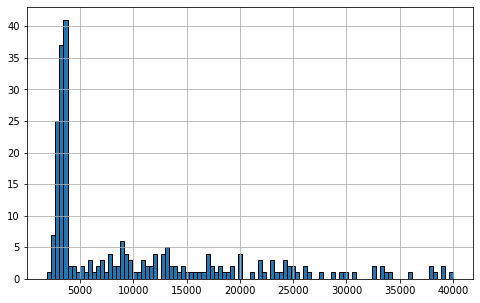

In [10]:
df['Temperature (K)'].hist(bins=100,ec='black', figsize=(8,5))
plt.show()

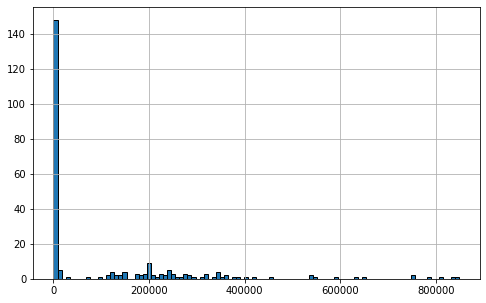

In [11]:
df['Luminosity(L/Lo)'].hist(bins=100,ec='black', figsize=(8,5))
plt.show()

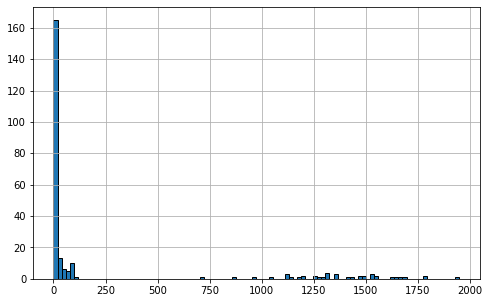

In [12]:
df['Radius(R/Ro)'].hist(bins=100,ec='black', figsize=(8,5))
plt.show()

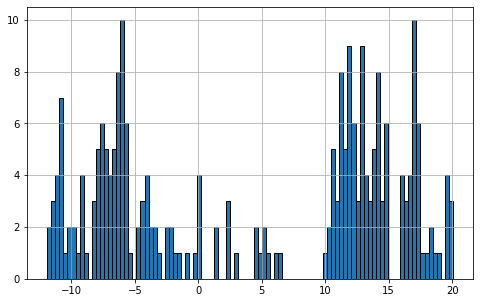

In [13]:
df['Absolute magnitude(Mv)'].hist(bins=100,ec='black', figsize=(8,5))
plt.show()

Кажется, что никаких аномалий на графиках нет. 
Посмотриим пропуски:

In [14]:
df.isna().mean()

Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
dtype: float64

пропусков нет

In [15]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
Orange                  2
yellowish               2
Whitish                 2
Blue-White              1
Blue white              1
Orange-Red              1
Pale yellow orange      1
Blue                    1
Yellowish               1
White-Yellow            1
Name: Star color, dtype: int64

есть косяки с названиеями категорий. исправим их:

In [16]:
df['Star color'] = df['Star color'].replace({'Blue White': 'Blue-white', 'Blue white':'Blue-white',
                                             'Blue white ':'Blue-white','Blue-White':'Blue-white',
                                             'Blue ':'Blue', 'white':'White', 'yellowish':'Yellowish',
                                             'yellow-white':'Yellow-white','White-Yellow':'Yellow-white',
                                             'Yellowish White':'Yellow-white','Pale yellow orange':'Pale-yellow-orange',
                                            'Whitish':'White'})

In [17]:
df['Star color'].value_counts()

Red                   112
Blue                   56
Blue-white             41
White                  12
Yellow-white           12
Yellowish               3
Orange                  2
Orange-Red              1
Pale-yellow-orange      1
Name: Star color, dtype: int64

## Построение базовой нейронной сети

In [18]:
df.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [19]:
cat = df[['Star color','Star type']]
num = df[['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']]

In [20]:
cat.columns

Index(['Star color', 'Star type'], dtype='object')

Произведем преобразование категориальных данных:

In [21]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)  # для преобразования категориальных данных

In [22]:
feature_arr = ohe.fit_transform(cat[cat.columns])
feature_labels = ohe.get_feature_names(cat.columns)
ohe_2 = pd.DataFrame(feature_arr, columns=feature_labels)

ohe_2.head()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Star color_Blue,Star color_Blue-white,Star color_Orange,Star color_Orange-Red,Star color_Pale-yellow-orange,Star color_Red,Star color_White,Star color_Yellow-white,Star color_Yellowish,Star type_0,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
data = df.merge(ohe_2, left_index=True, right_index=True)
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Star color_Blue,Star color_Blue-white,Star color_Orange,Star color_Orange-Red,...,Star color_Red,Star color_White,Star color_Yellow-white,Star color_Yellowish,Star type_0,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5
0,3068,0.002400,0.1700,16.12,0,Red,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3042,0.000500,0.1542,16.60,0,Red,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2600,0.000300,0.1020,18.70,0,Red,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2800,0.000200,0.1600,16.65,0,Red,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1939,0.000138,0.1030,20.06,0,Red,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
x= data.drop(['Temperature (K)','Star color'], axis=1)
y = df['Temperature (K)']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=42)

In [25]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [26]:
num_cols = x.columns[x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [27]:
pd.options.mode.chained_assignment = None

Произведем преобразование числовых данных:

In [28]:
num.columns

Index(['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'], dtype='object')

In [29]:
scaler.fit(X_train[num.columns])
X_train[num.columns] = scaler.transform(X_train[num.columns])
X_test[num.columns] = scaler.transform(X_test[num.columns])

In [30]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [31]:
print('Кол-во строк и столбцов в X_train выборке:', X_train.shape)
print('Кол-во строк и столбцов в X_test выборке:', X_test.shape)
print('Кол-во строк и столбцов в y_train выборке:', y_train.shape)
print('Кол-во строк и столбцов в y_test выборке:', y_test.shape)

Кол-во строк и столбцов в X_train выборке: torch.Size([144, 19])
Кол-во строк и столбцов в X_test выборке: torch.Size([96, 19])
Кол-во строк и столбцов в y_train выборке: torch.Size([144])
Кол-во строк и столбцов в y_test выборке: torch.Size([96])


In [32]:
torch.use_deterministic_algorithms(True)

In [33]:
n_in_neurons = 19
n_hidden_neurons_1 = 7
n_hidden_neurons_2 = 12
n_out_neurons = 1

In [34]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [35]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=4)
num_epochs = 1000
batch_size = 20
num_batches = ceil(len(X_train)/batch_size)

In [36]:
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = net.forward(X_batch)
        loss_value = torch.sqrt(loss(y_test, preds))
        loss_value.backward()
                
        optimizer.step()

    
    if epoch % 100 == 0:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE_loss = torch.sqrt(loss(y_test, preds))
        print('RMSE Метрика',RMSE_loss)

/home/jovyan/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)


/home/jovyan/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)
RMSE Метрика tensor(14447.3418, grad_fn=<SqrtBackward0>)


Построим график Факт-Прогноз:

In [37]:
def graph_predict(x,y):
        
    pred = np.asarray(list(itertools.chain.from_iterable(x.data.numpy())))
    
    barWidth1 = 1
    barWidth2 = 0.5
    x_range = np.arange(len(y))
    
    plt.bar(x_range, y.data.numpy(), color='#aae6f2', width=barWidth1/2, edgecolor='#c3d5e8', label='Факт')
    plt.bar(x_range, pred, color='#ffc001', width=barWidth2/2, edgecolor='#c3d5e8', label='Прогноз')
    
    plt.axhline(y=0, color='gray')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':25}, ncol = 2)
    plt.ylabel("Температура звезды", fontsize=28, weight='bold')
    plt.xlabel("Номер звезды в таблице данных", fontsize=28, weight='bold')
    
    plt.rcParams['figure.figsize'] = [25, 7]
    
    plt.rcParams.update({'font.size': 28})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

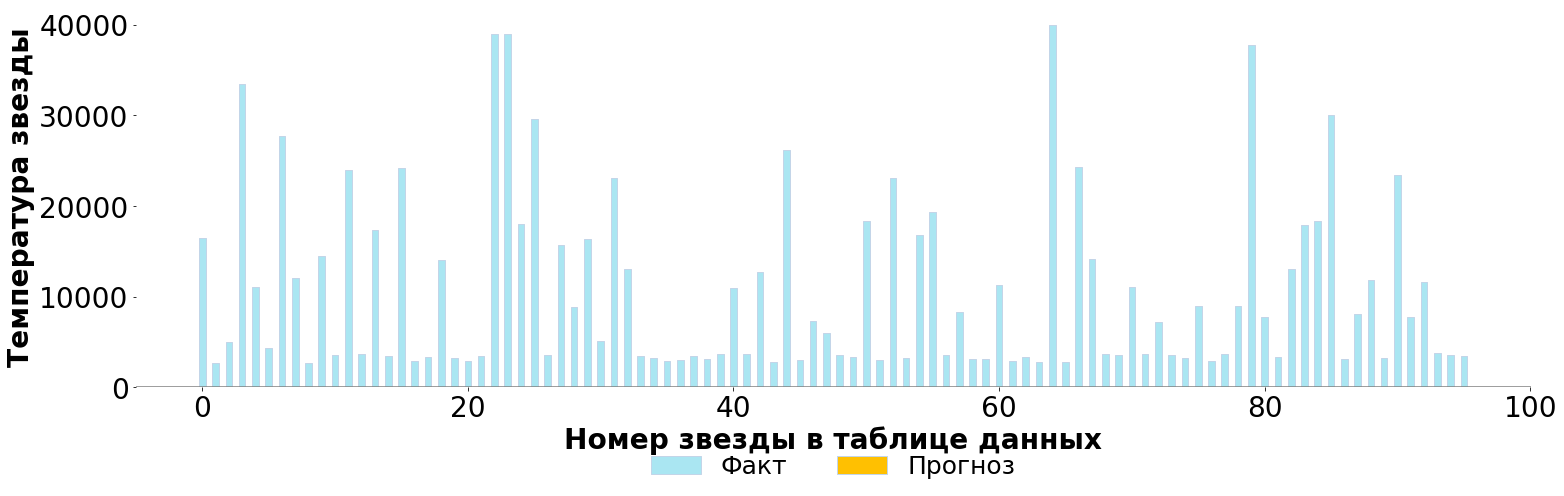

In [49]:
graph_predict(test_preds,y_test)

По условию метрика RMSE не должна превышать 4500, а у нас получилось 9819. Слишком много, сеть явно переучивается. Попробуем улучшить сеть

## Улучшение нейронной сети

Улучшим нашу модель используя одновременно и нормализацию батчей, и дропаут:

In [39]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.7)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [40]:
n0 = df.shape[1]

In [41]:
def neural_network(n0:int, n1:int, n2:int, nout:int, e:int, x_tr:'tentor', y_tr:'tentor', x_te:'tentor', y_te:'tentor')->'tuple':

    n0 = x_tr.size()[1]
    nout = 1
    net = Net(n0,n1,n2,nout)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=4)
    num_epochs = e
    
    preds = net.forward(X_train).flatten()
    RMSE_loss = torch.sqrt(loss(preds, y_train))
    
    best_RMSE = RMSE_loss
    best_epoch = 0
    best_model = 1
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X_train).flatten()
        RMSE_loss = torch.sqrt(loss(preds, y_train))
        RMSE_loss.backward()
        if best_RMSE > RMSE_loss:
            best_RMSE = RMSE_loss
            best_epoch = epoch
            best_model = net
        optimizer.step()
    return (best_RMSE.tolist(), n1, n2, best_epoch, best_model)

result_list = []
n1_r = range(1,61, 10)
n2_r = range(1,61, 10)
e_r = range(1,1001, 100)

for n1_i in n1_r:
    for n2_i in n2_r:
        for e_i in e_r:
            a = neural_network(n0,n1_i,n2_i,1,e_i, X_train, y_train, X_test, y_test)
            result_list.append(a)
    print(n1_i)

1
11
21
31
41
51


In [42]:
result_df = pd.DataFrame(result_list).loc[::,:4]
result_df=result_df.rename(columns={0:'RMSE',1:'n1',2:'n2',3:'epochs',4:'best_model'})
result_df.sort_values('RMSE').head()

,RMSE,n1,n2,epochs,best_model
289,4162.907715,41,41,741,"Net(\n (fc1): Linear(in_features=19, out_feat..."
349,4171.095703,51,41,534,"Net(\n (fc1): Linear(in_features=19, out_feat..."
295,4177.213379,41,51,421,"Net(\n (fc1): Linear(in_features=19, out_feat..."
355,4178.160156,51,51,340,"Net(\n (fc1): Linear(in_features=19, out_feat..."
347,4180.365234,51,41,690,"Net(\n (fc1): Linear(in_features=19, out_feat..."


In [43]:
best_m = result_df.loc[349,'best_model']
best_m

Net(
  (fc1): Linear(in_features=19, out_features=51, bias=True)
  (dp1): Dropout(p=0.7, inplace=False)
  (act1): ReLU()
  (fc2): Linear(in_features=51, out_features=41, bias=True)
  (bn2): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=41, out_features=1, bias=True)
  (act3): ReLU()
)

In [44]:
new_test_preds = best_m.forward(X_test)

In [45]:
df_test_preds = pd.DataFrame(new_test_preds.detach().numpy())

In [46]:
df_test_preds=df_test_preds.rename(columns={0:'preds'})
df_test_preds.query('0<preds<4500')

,preds
12,896.521118
39,2843.674316
80,2097.785400
87,4005.895752
93,398.848816


Удалось улучшить модель до показателей ниже 4500!

Строим график:

In [47]:
def graph_predict(x,y):
        
    test_pred = np.asarray(list(itertools.chain.from_iterable(x.data.numpy())))
    
    barWidth1 = 1
    barWidth2 = 0.5
    x_range = np.arange(len(y))
    
    plt.bar(x_range, y.data.numpy(), color='#aae6f2', width=barWidth1/2, edgecolor='#c3d5e8', label='Факт')
    plt.bar(x_range, test_pred, color='#ffc001', width=barWidth2/2, edgecolor='#c3d5e8', label='Прогноз')
    
    plt.axhline(y=0, color='gray')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':25}, ncol = 2)
    plt.ylabel("Температура звезды", fontsize=28, weight='bold')
    plt.xlabel("Номер звезды в таблице данных", fontsize=28, weight='bold')
    
    plt.rcParams['figure.figsize'] = [25, 7]
    
    plt.rcParams.update({'font.size': 28})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

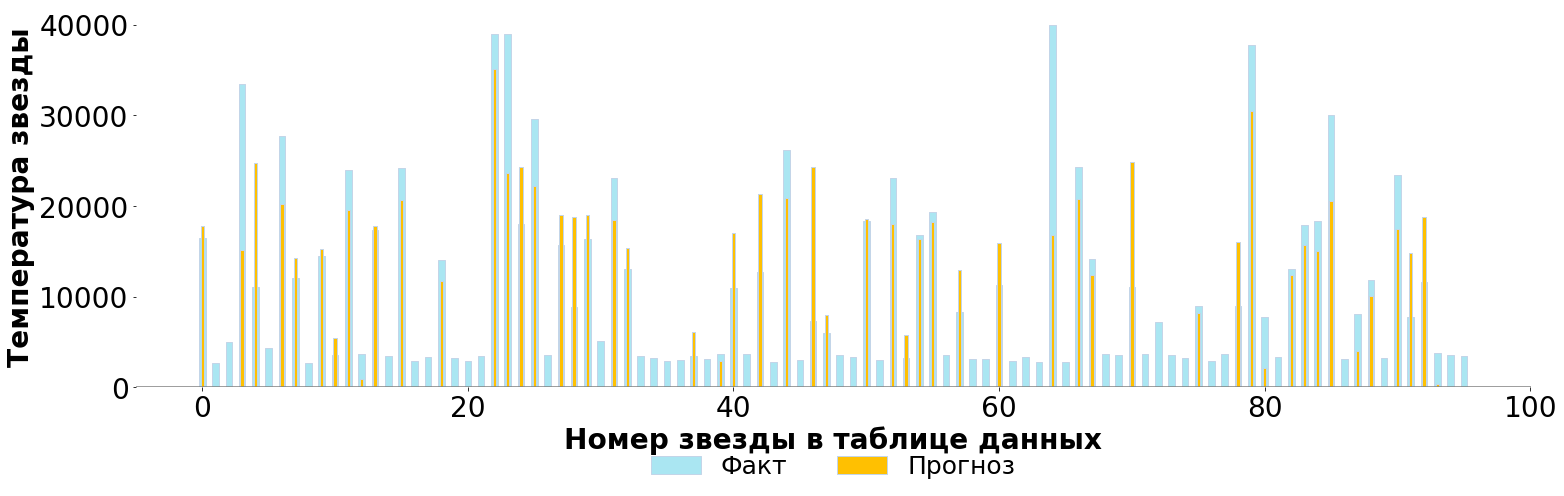

In [48]:
graph_predict(new_test_preds,y_test)

## Выводы

**Базовая модель**

Базовая модель была построена с параметрами: 
- n_in_neurons = 19
- n_hidden_neurons_1 = 51
- n_hidden_neurons_2 = 41
- n_out_neurons = 1
- optimizer = torch.optim.Adam(model.parameters(), lr=4)
- loss = nn.MSELoss()
- batch_size = 20
- num_epochs = 1000
- accumulation_iteration = 100
- num_batches = ceil(len(X_train)/batch_size)
- выходная функция ReLU

Данная модель оказалась неэффективна. Метрика RMSE получилась > 9 тыс, что нас не удовлетворяло, так как по условию нужно было получить метрику не выше 4500. 

**Улучшенная модель**
- улучшенная модель строилась с использованием как батчей, так и метода droupout
- использовался перебор параметров входных нейронов и эпох:
  - n1_r = range(1,51, 10)
  - n2_r = range(1, 51, 10)
  - e_r = range(1,1001, 100)
- наилучшая модель имела показатели:
  - n1_r =19
  - n2_r = 1
  - n3_r = 21
  - n_out = 1
  - bias = True
  - Dropout-1 p=0.7
  - Dropout-2 p=0.2
  - выходная функция ReLU
  
Данную модель можно считать эффективной. Метрика RMSE получилась < 4500

Сравнивая два графика, можно явно увидеть как плохо обучалась базовая модель (как много делала ошибок) и насколько лучше стала предсказывать после улучшения! 